# Expoloring the Credit Card Fraud Detection Dataset

The following dataset is available on Kaggle, and includes anonymized credit card transactions by Equropean cardholders over a two day period in September 2013. Transactions are labelled as either fraudulent or legitimate.

Each transaction contains 28 numerical features which have been transformed using PCA to keep the transactions anonymous. Each transaction also contains a time feature, which represents the number of seconds elapsed since the first transaction in the dataset, and the 'Amount,' or value of the transaction.

The dataset and discussion is as available here:

https://www.kaggle.com/mlg-ulb/creditcardfraud

The Imbalanced Learn and Light GBM modules are available here:

https://github.com/scikit-learn-contrib/imbalanced-learn

https://github.com/Microsoft/LightGBM/tree/master/python-package

In [29]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

# XGBoost
import xgboost as xgb

# Microsoft's LightGBM
import lightgbm as lgb

# Synthetic Minority Over-Sampling Technique (SMOTE)
from imblearn.over_sampling import SMOTE

### Definitions

The following functions are used for resampling the data and visualizing differences in the fraudulent and legitimate transaction data.

__resample_and_balance__ resamples the data so that the fraudulent and legitimate purchases are balanced and contain 'num' examples of each. 

Returns a dataframe containing 'num' randomly selected original legitimate transactions and  'num' fraudulent transactions consisting of the original fraudulent transactions plus transactions simulated using SMOTE.

SMOTE (Synthetic Minority Over-Sampling Technique) is a way to create a balanced data set, using the imblearn python package
    
__dist_compare__ creates two histograms to quickly compare how the data are distributed

In [4]:
def resample_and_balance(X,y, num=1000):
    
    # Select original fraudulent transactions
    df_all = pd.concat([X,y], axis=1)
    df_fraud_original = df_all.loc[df_all.Class == 1]
    num_original = len(df_fraud_original)

    # SMOTE Resampling
    X_ = X.as_matrix()
    y_ = np.ravel(y.as_matrix())
    ratio_dict = {0: sum(y.Class == 0), 1: num}
    
    smote = SMOTE(ratio=ratio_dict, random_state=42)
    
    X_resampled, y_resampled = smote.fit_sample(X_, y_)
    
    resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                           pd.DataFrame(y_resampled, columns=['Class'])], 
                           axis=1)
    
    # Select simulated fraudulent transactions created using SMOTE                      
    df_fraud_resample = resampled.loc[resampled.Class == 1]
    df_fraud_resample = df_fraud_resample.sample(n = num - num_original, replace=False)
    
    df_fraud = pd.concat([df_fraud_original, df_fraud_resample], axis=0)

    # Sample original legitimate transactions to match 
    # length of resampled original trnsactions
    df_legit = df_all.loc[df_all.Class == 0]
    df_legit = df_legit.sample(n=num, replace=False, random_state=42)

    return(df_legit, df_fraud)

def dist_compare(var):
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,2,1, yticks=[])
    ax.set_xlim(min(df_legit[var]) -1 , max(df_legit[var]) + 1)
    ax.set_title('Legitimate Purchases, %s' %(var))
    sns.distplot(df_legit[var], bins=100)
    ax = fig.add_subplot(1,2,2, yticks = [])
    ax.set_xlim(min(df_legit[var]) -1 , max(df_legit[var]) + 1)
    ax.set_title('Fraudulent Purchases, %s' %(var))
    sns.distplot(df_fraud[var], bins=100)
    display.clear_output()
    plt.show()


### Read and pre-process data

In [5]:
df = pd.read_csv('creditcard.csv')

X = df.drop(['Class'], axis=1)

# For now,m drop the time feature
X = X.drop(['Time'], axis=1)
y = pd.DataFrame()
y['Class'] = df.Class

# Scale the 'Amount' feature
X['Amount'] = StandardScaler().fit_transform(X.Amount.values.reshape(-1,1))
X.describe()

print('There are %i instances of fraud from %i transactions' %(np.sum(y), len(y)))

# Set aside 25% of data to test on later

X, X_holdout, y, y_holdout = train_test_split(X, y, test_size = 0.25, random_state=42)

# Use resample function to create resampled dataset

num = 4000 # Number of instances of fraud in balanced dataset 

df_legit, df_fraud = resample_and_balance(X, y, num = num) 

df_all = pd.concat([df_legit, df_fraud], axis=0)

X_r = df_all.drop(['Class'], axis=1)
y_r = df_all.Class

# Convert y to 1-D
y = np.ravel(y)

# Create a dataframe to hold feature coeficients
FeatureCoefs = pd.DataFrame(index=X.columns)

There are 492 instances of fraud from 284807 transactions


### EDA

#### Distributions of the variables

With the dist_compare method we can explore the variables in the dataset to see if any are distributed differently. Some features show very little variation in the distribution between the fraudulent and legitimate transactions (such as Variable 19), others appear to have differing distributions (such as V4).

We can see if these differences show up later when we compare how each model ranks the importance of a few features.

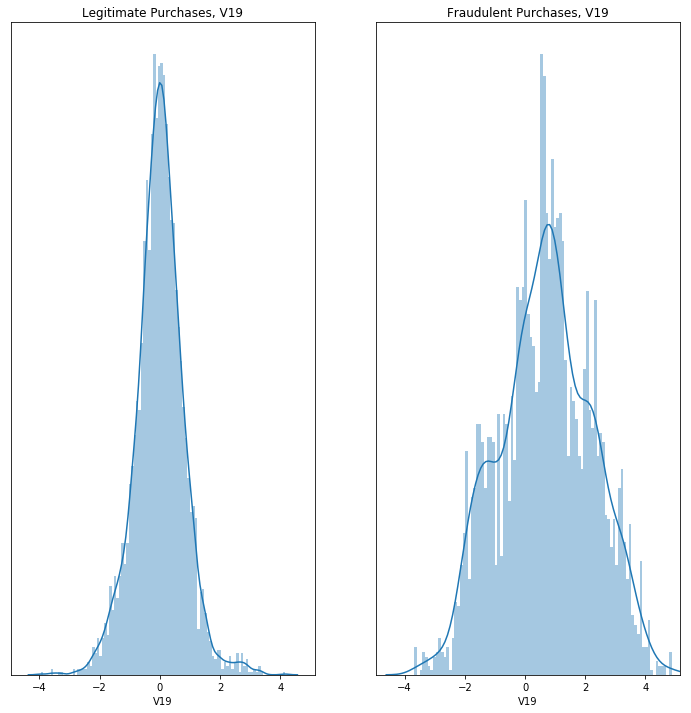

In [22]:
dist_compare('V19')

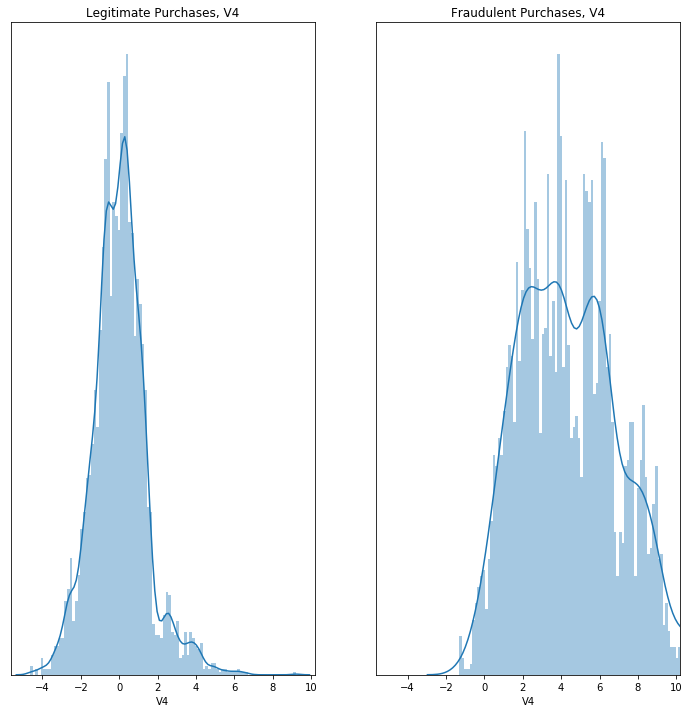

In [24]:
dist_compare('V4')

#### Dimensionality reduction

Once the fraudulent and legitimate data have been augmented and balanced using SMOTE, we can try using t-SNE to visualize differences in fraudulent and legitimate transactions in two dimensions. 

Since there are only 29 features being used, there is no need to reduce the dimensionality of the data before performing t-SNE.


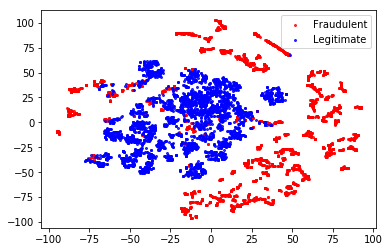

In [5]:
tsne = TSNE(n_components=2, learning_rate=200, random_state=42)

X_new = tsne.fit_transform(X_r)

XY = pd.DataFrame(np.column_stack((X_new, y_r)), columns=['x','y','label'])

fraud = XY.loc[XY['label'] == 1].values
legit = XY.loc[XY['label'] == 0].values

ax, fig = plt.subplots()

ax = sns.regplot(fraud[:,0], fraud[:,1], color='r', scatter=True, fit_reg=False, scatter_kws={'s': 4})
ax = sns.regplot(legit[:,0], legit[:,1], color='b', scatter=True, fit_reg=False, scatter_kws={'s': 4})
ax.legend(labels = ['Fraudulent','Legitimate'], loc='best')
plt.show()

The separate clusters of fraudulent and legitimate transactions in the two dimensional representation generated using t-SNE suggests that there are differences in the data that could be used to predict whether a transaction is fraudulent. Applying various machine learning algorithms should enable the two types of transactions to be distinguished.

The next question is how to evaluate the performance of various models. Since fraudulent transactions are very rare (we saw that less than 0.2% of the transactions in the dataset are fraudulent), an __accuracy score__ would be nearly meaningless, as a highly accurate machine learning algorithm could just be pointing out that most credit card transactions are legitimate, which isn't particularly interesting.

A better metric for evaluating the relevance of the model would be __Area Under the Precision-Recall Curve (AUPRC)__, which can be used for tuning model parameters.

The model __precision score__ would be very sensitive to false positives, while the __recall score__ is sensitive to false negatives. In this case, our goal is to flag most true positive results. Since fraudulent transactions are rare, and the consequences of occasionally flagging a legitimate purchase as fraudulent aren't too significant, it makes the most sense to ultimately select a model with high recall at the expense of lower precision.

### Models

#### Logistic Regression

Start with a logistic regression model. First optimize model parameters, such as inverse of regularization strength ('C'):

In [8]:
params = [1, 5, 10, 15, 20]

for param in params:
    logreg = LogisticRegression(penalty='l1', # Default 
                                tol=0.0001,   # Default
                                C = param)    # 5
    
    scoring = ['precision', 'recall', 'f1', 'roc_auc']
    
    scores = cross_validate(logreg, X, y, scoring=scoring, cv=5, return_train_score=False)
    print('Tol: %f' %(param))
    print('Logistic Regression CV Scores, Original Data:\nprecision:\t%f \nreacll:\t\t%f\nf1:\t\t%f\nroc-auc:\t%f' 
            %(np.mean(scores.get('test_precision')), 
            np.mean(scores.get('test_recall')),
            np.mean(scores.get('test_f1')),
            np.mean(scores.get('test_roc_auc'))
            )
         )


Tol: 1.000000
Logistic Regression CV Scores, Original Data:
precision:	0.890758 
reacll:		0.628246
f1:		0.734244
roc-auc:	0.976101
Tol: 5.000000
Logistic Regression CV Scores, Original Data:
precision:	0.894951 
reacll:		0.630912
f1:		0.737167
roc-auc:	0.975262
Tol: 10.000000
Logistic Regression CV Scores, Original Data:
precision:	0.894951 
reacll:		0.630912
f1:		0.737167
roc-auc:	0.975150
Tol: 15.000000
Logistic Regression CV Scores, Original Data:
precision:	0.894951 
reacll:		0.630912
f1:		0.737167
roc-auc:	0.975109
Tol: 20.000000
Logistic Regression CV Scores, Original Data:
precision:	0.894951 
reacll:		0.630912
f1:		0.737167
roc-auc:	0.975089


C of ~ 5 works best.

Using optimized model parameters, fit the model to the training data, then compare model results from the original unbalanced data and the resampled data. Compare model classification results.

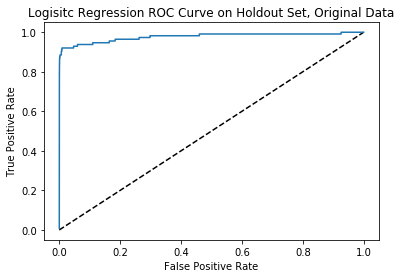

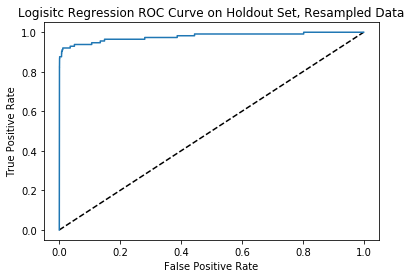

Original Logreg AUC Score: 0.977337
Resampled Logreg AUC Score: 0.978291
Original Data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.84      0.60      0.70       113

avg / total       1.00      1.00      1.00     71202

Resampled Data
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     71089
          1       0.06      0.92      0.12       113

avg / total       1.00      0.98      0.99     71202



In [7]:
# Logistic regression model

logreg = LogisticRegression(penalty='l1', # Default 
                            tol=0.0001,   # Default
                            C = 5)        #5
# Original data

logreg.fit(X,y)
preds = logreg.predict(X_holdout)
preds_proba = logreg.predict_proba(X_holdout)[:,1]

fpr, tpr, thresholds = roc_curve(y_holdout, preds_proba)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logisitc Regression ROC Curve on Holdout Set, Original Data')
plt.show()

auc = roc_auc_score(y_holdout, preds_proba)

# Scale and save feature weights
logreg_coefs_o = logreg.coef_
logreg_coefs_o = StandardScaler().fit_transform(logreg_coefs_o[0].reshape(-1,1))
FeatureCoefs['logreg_original'] = logreg_coefs_o

# Resampled data

logreg.fit(X_r.as_matrix(), y_r)
preds_r = logreg.predict(X_holdout)
preds_proba_r = logreg.predict_proba(X_holdout)[:,1]

fpr, tpr, thresholds = roc_curve(y_holdout, preds_proba_r)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logisitc Regression ROC Curve on Holdout Set, Resampled Data')
plt.show()

auc_r = roc_auc_score(y_holdout, preds_proba_r)

# Scale and save feature weights
logreg_coefs_r = logreg.coef_
logreg_coefs_r = StandardScaler().fit_transform(logreg_coefs_r[0].reshape(-1,1))
FeatureCoefs['logreg_resample'] = logreg_coefs_r

# Logreg Summaries
print('Original Logreg AUC Score: %f' %(auc))
print('Resampled Logreg AUC Score: %f' %(auc_r))
print('Original Data')
print(classification_report(y_holdout, preds))
print('Resampled Data')
print(classification_report(y_holdout, preds_r))

The resampled data significantly improves the recall score on the logistic regression model, catching over 90% of the fraudulent transactions. This appears to be as the expense of a lot of legitimate transactions being mislabeled (less than 1 in 15 transactions flagged by this model would actually be fraudulent).

Next, investigate whether XGBoost can improve on this score.

#### XGBoost

Repeat the process with and XGBoost model. First, use grid search to optimize XGBoost model parameters, using area under the receiver-operator characteristic curve to select the best parameters (grid search terms not included here, just the optimal parameters found using a grid search):

In [9]:
xgb_model = xgb.XGBClassifier()

parameters = {'max_depth': [7],
              'learning_rate': [0.001],
              'n_estimators': [1000],
              'objective': ['binary:logistic'],
              'gamma': [0],
              'min_child_weight': [6],
              'subsample': [0.7],
              'colsample_bytree': [0.5]}

clf = GridSearchCV(xgb_model, 
                   param_grid=parameters, 
                   scoring='roc_auc', 
                   n_jobs=-1, 
                   cv=3)

clf.fit(X,y)

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('AUC score:', score)

for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

AUC score: 0.936796045859
colsample_bytree: 0.5
gamma: 0
learning_rate: 0.001
max_depth: 7
min_child_weight: 6
n_estimators: 1000
objective: 'binary:logistic'
subsample: 0.7


Again, compare model performance between the original data and the resampled data.

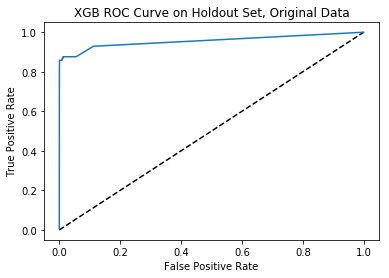

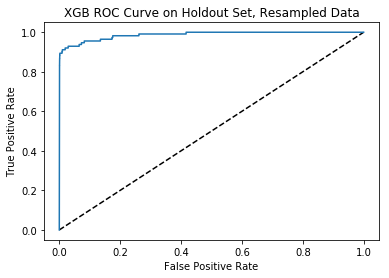

Original XGB AUC Score: 0.955910
Resampled XGB AUC Score: 0.986960
Original Data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.89      0.71      0.79       113

avg / total       1.00      1.00      1.00     71202

Resampled Data
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     71089
          1       0.16      0.89      0.27       113

avg / total       1.00      0.99      1.00     71202



In [10]:
# Original data
preds = clf.predict(X_holdout)
preds_proba = clf.predict_proba(X_holdout)[:,1]

fpr, tpr, thresholds = roc_curve(y_holdout, preds_proba)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='XGB Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve on Holdout Set, Original Data')
plt.show()

auc = roc_auc_score(y_holdout, preds_proba)

# Scale and save feature weights
xgb_coefs_o = clf.best_estimator_.feature_importances_
xgb_coefs_o = StandardScaler().fit_transform(xgb_coefs_o.reshape(-1,1))
FeatureCoefs['xgb_original'] = xgb_coefs_o

# Resampled data

clf.fit(X_r, y_r)
preds_r = clf.predict(X_holdout)
preds_proba_r = clf.predict_proba(X_holdout)[:,1]
X_holdout.shape
X_r.shape
fpr, tpr, thresholds = roc_curve(y_holdout, preds_proba_r)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='XGB Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve on Holdout Set, Resampled Data')
plt.show()

auc_r = roc_auc_score(y_holdout, preds_proba_r)

# Scale and save feature weights
xgb_coefs_r = clf.best_estimator_.feature_importances_
xgb_coefs_r = StandardScaler().fit_transform(xgb_coefs_r.reshape(-1,1))
FeatureCoefs['xgb_resample'] = xgb_coefs_r

# XGB Summaries
print('Original XGB AUC Score: %f' %(auc))
print('Resampled XGB AUC Score: %f' %(auc_r))
print('Original Data')
print(classification_report(y_holdout, preds))
print('Resampled Data')
print(classification_report(y_holdout, preds_r))

#### Light GBM

Repeat the process with and Microsoft's Light GBM model. Again, use grid search to optimize Light GBM model parameters, using area under the receiver-operator characteristic curve:

In [25]:
lgb_train = lgb.Dataset(X, y, free_raw_data=False)

lgb_holdout = lgb.Dataset(X_holdout, y_holdout, free_raw_data=False)

parameters = {'num_leaves': [70],
              'max_depth' : [7],
              'n_estimators' : [100],
              'min_child_weight' : [0.0001],
              'min_child_samples' : [50, 75, 100],
              'subsample ' : [1],
              'colsample_bytree': [0.5] ,
              'reg_alpha' : [0],
              'reg_lambda' : [0],
              'random_state': [42]}
              

gbm_model = lgb.LGBMClassifier(boosting_type = 'gbdt',
                               objective = 'binary',
                               learning_rate = 0.01,
                               n_jobs = -1,
                               silent = False)

clf = GridSearchCV(gbm_model, 
                   param_grid=parameters,
                   scoring='roc_auc', 
                   n_jobs=-1, 
                   cv=3)

clf.fit(X, y)

best_parameters = clf.best_params_
score = clf.best_score_
print('AUC score:', score)

for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

AUC score: 0.978792509485
colsample_bytree: 0.5
max_depth: 7
min_child_samples: 100
min_child_weight: 0.0001
n_estimators: 100
num_leaves: 70
random_state: 42
reg_alpha: 0
reg_lambda: 0
subsample : 1


And compare model performance between the original data and the resampled data:

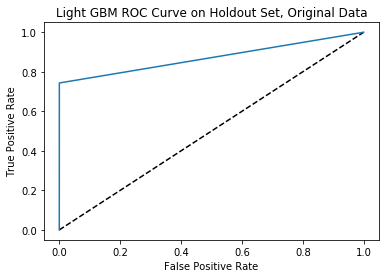

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


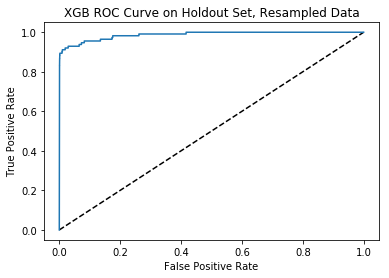

Original LGBM AUC Score: 0.871583
Resampled LGBM AUC Score: 0.986960
Original Data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.89      0.71      0.79       113

avg / total       1.00      1.00      1.00     71202

Resampled Data
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     71089
          1       0.17      0.89      0.28       113

avg / total       1.00      0.99      1.00     71202



C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [26]:
# Original Data
preds_proba = clf.predict(X_holdout)

fpr, tpr, thresholds = roc_curve(y_holdout, preds_proba)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Light GBM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Light GBM ROC Curve on Holdout Set, Original Data')
plt.show()

auc = roc_auc_score(y_holdout, preds_proba)

# Scale and save feature weights
lgb_coefs_o = clf.best_estimator_.feature_importances_
lgb_coefs_o = StandardScaler().fit_transform(lgb_coefs_o.reshape(-1,1))
FeatureCoefs['lgb_original'] = lgb_coefs_o

# Resampled Data
clf.fit(X_r, y_r)
preds_r = clf.predict(X_holdout)
#preds_proba_r = clf.predict_proba(X_holdout)[:,1]
X_holdout.shape
X_r.shape
fpr, tpr, thresholds = roc_curve(y_holdout, preds_proba_r)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='XGB Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve on Holdout Set, Resampled Data')
plt.show()

auc_r = roc_auc_score(y_holdout, preds_proba_r)

# Scale and save feature weights
lgb_coefs_r = clf.best_estimator_.feature_importances_
lgb_coefs_r = StandardScaler().fit_transform(lgb_coefs_r.reshape(-1,1))
FeatureCoefs['lgb_resample'] = lgb_coefs_r

# Light GBM Summaries
print('Original LGBM AUC Score: %f' %(auc))
print('Resampled LGBM AUC Score: %f' %(auc_r))
print('Original Data')
print(classification_report(y_holdout, preds))
print('Resampled Data')
print(classification_report(y_holdout, preds_r))

### Feature Importance

Finally, we can compare how each model weighted the various features. For a quick comparison, take the absolute value of the feature importance and scale them using Scikitlearn's Standard Scaler.

The models do vary in which features are incorporated, but there are some patterns that we suspected from comparing the variable distributions that become apparent (V4, V14 and V12 appear to be significant features, while V23, V13 and V15 are less predictive).

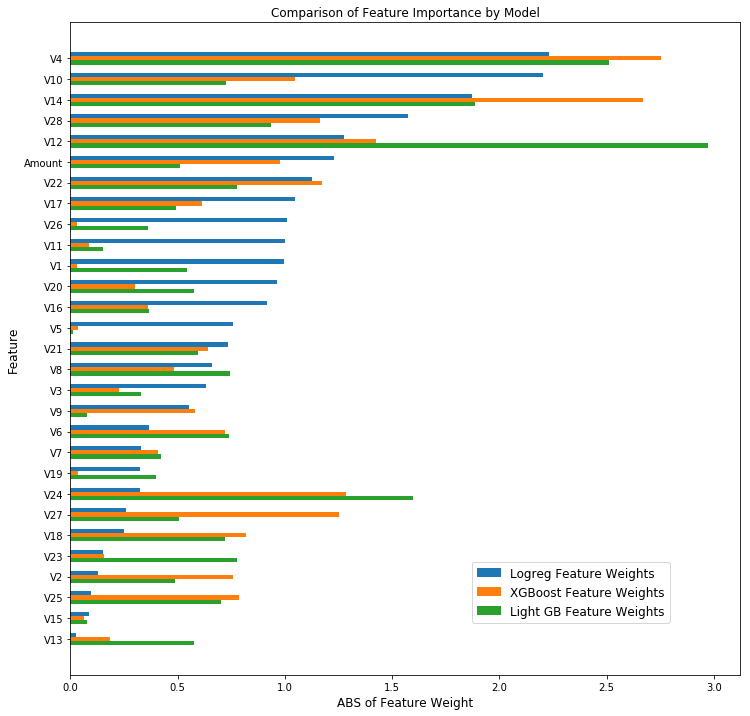

In [32]:
FeatureCoefs = FeatureCoefs.abs()

FeatureCoefs = FeatureCoefs.sort_values(by=['logreg_resample'], ascending=True)

FeatureCoefs.head()

fig, ax = plt.subplots(figsize=(12,12))
y_pos = np.arange(0,29,1)
ax.barh(y=y_pos + 0.2, width=FeatureCoefs.logreg_resample, height=0.2)
ax.barh(y=y_pos, width=FeatureCoefs.xgb_resample, height=0.2)
ax.barh(y=y_pos - 0.2, width=FeatureCoefs.lgb_resample, height=0.2)
ax.legend(['Logreg Feature Weights', 'XGBoost Feature Weights', 'Light GB Feature Weights'], loc=(0.6, 0.08), fontsize='large')
plt.yticks(y_pos, FeatureCoefs.index)
plt.ylabel('Feature', fontsize='large')
plt.xlabel('ABS of Feature Weight', fontsize='large')
plt.title('Comparison of Feature Importance by Model')
plt.show()

Finally, a quick review of the models. Which model is the 'best' depends on the tradeoff between catching a fraudulent transaction and inadvertently contacting the customer with a false alarm.

From all three models we can see augmenting the data using SMOTE significantly increases the model recall, with the logistic regression model achieving the highest recall (0.92).

LightGBM achieves a comparable recall (0.89), but with far fewer false alarms (a precision of 0.17), and has the added benefit of being a quicker model to fit than XGBoost.

#### Logistic Regression

Original Logreg AUC Score: 0.977337
Resampled Logreg AUC Score: 0.978291
Original Data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.84      0.60      0.70       113

avg / total       1.00      1.00      1.00     71202

Resampled Data
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     71089
          1       0.06      0.92      0.12       113

avg / total       1.00      0.98      0.99     71202

#### XGBoost

Original XGB AUC Score: 0.955910
Resampled XGB AUC Score: 0.986960
Original Data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.89      0.71      0.79       113

avg / total       1.00      1.00      1.00     71202

Resampled Data
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     71089
          1       0.16      0.89      0.27       113

avg / total       1.00      0.99      1.00     71202

#### LightGBM

Original LGBM AUC Score: 0.871583
Resampled LGBM AUC Score: 0.986960
Original Data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.89      0.71      0.79       113

avg / total       1.00      1.00      1.00     71202

Resampled Data
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     71089
          1       0.17      0.89      0.28       113

avg / total       1.00      0.99      1.00     71202


To further improve the model, we could explore combining the model outputs. Since the model feature weights vary, combining the model predictions (using Feature-Weighted Linear Stacking) could improve performance. 

We could also look into deep learning (neural net) models to explore feature interactions and possibly improve performance.